# Franklin Umkondo

Just assess Franklin and Umkondo.

In [1]:
import sys
sys.version_info

sys.version_info(major=2, minor=7, micro=15, releaselevel='final', serial=0)

In [2]:
import numpy as np
from numpy.core.umath_tests import inner1d
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import pygplates

import cartopy
import cartopy.crs as ccrs
from shapely.geometry.polygon import Polygon

from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

from tqdm import tqdm_notebook

from netCDF4 import Dataset

/Users/yuempark/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  


In [3]:
from recon_tools import lat_lon_2_cart
from recon_tools import cart_2_lat_lon
from recon_tools import fast_cross
from recon_tools import cross_and_normalize
from recon_tools import intersection
from recon_tools import check_polygon_in_band
from recon_tools import get_area_in_band
from recon_tools import get_areas_in_bands
from recon_tools import get_length_in_band
from recon_tools import get_lengths_in_bands
from recon_tools import plot_reconstruction
from recon_tools import plot_polygons

In [4]:
def get_LIP_areas_in_bands(reconstructed_feature_geometries, lat_mins, lat_maxs,
                           halflife, cover_removal, cover_halflife):
    """
    Get the area of all features in each latitude band, with optional calculations for:
    - features decaying exponentially
    - covered features disappearing and other features decaying exponentially

    Parameters
    ----------
    reconstructed_feature_geometries : list
        list of reconstructed features
    lat_mins : array-like
        array-like of latitude minimums
    lat_maxs : array_like
        array_like of latitude maximums
    halflife : array-like
        half life of exponential decay
    cover_removal : list of booleans
        if True, instantly remove, if False, remove 50% instantly
    cover_halflife : array-like
        halflife of the uncovered features

    Returns
    -------
    areas : array
        list of total area in each latitude band
    area_polygons : list
        list of all polygons for which areas were calculated
    areas_decay : list of arrays
        list of total area in each latitude band, accounting for exponential decay method
    areas_cover : list of arrays
        list of total area in each latitude band, accounting for cover method
    """
    # storage vectors
    areas = np.array([])
    area_polygons = []
    
    areas_decay_temp = []
    # convert halflife to decay constant
    lamb = np.log(2)/halflife
    
    areas_cover_temp = []
    cover_lamb = np.log(2)/cover_halflife

    # iterate over each latitude band
    for i in range(len(lat_mins)):

        accumulated_area = 0

        accumulated_area_decay = np.zeros(len(halflife))
        accumulated_area_cover = np.zeros(len(cover_halflife))

        # iterate over each polygon
        for j in range(len(reconstructed_feature_geometries)):

            # get the begin date, reconstruction date, and feature age
            begin_date, end_date = reconstructed_feature_geometries[j].get_feature().get_valid_time()
            now_date = reconstructed_feature_geometries[j].get_reconstruction_time()
            feature_age = begin_date - now_date
            feature_name = reconstructed_feature_geometries[j].get_feature().get_name()
            feature_Id = reconstructed_feature_geometries[j].get_feature().get_feature_id().get_string()

            # get the actual polygon
            current_polygon = reconstructed_feature_geometries[j].get_reconstructed_geometry()

            # check if the polygon is in the band
            in_band = check_polygon_in_band(current_polygon, lat_mins[i], lat_maxs[i])

            if in_band:
                # do the calculation
                area, band_polygon = get_area_in_band(current_polygon, lat_mins[i], lat_maxs[i])

                # store results
                if begin_date<=520:
                    accumulated_area = accumulated_area + area
                area_polygons.append(band_polygon)

                # decay method
                for k in range(len(halflife)):
                    # scale the area based on the exponential decay equation
                    decay_area = area * np.exp(-lamb[k]*feature_age)
                    accumulated_area_decay[k] = accumulated_area_decay[k] + decay_area
                        
                # cover method
                if feature_name in covered_LIP_names:
                    for k in range(len(cover_halflife)):
                        if cover_removal[k]:
                            pass
                        else:
                            decay_area = area/2 * np.exp(-cover_lamb[k]*feature_age)
                            accumulated_area_cover[k] = accumulated_area_cover[k] + decay_area
                else:
                    for k in range(len(cover_halflife)):
                        # scale the area based on the exponential decay equation
                        decay_area = area * np.exp(-cover_lamb[k]*feature_age)
                        accumulated_area_cover[k] = accumulated_area_cover[k] + decay_area
                        
        # store total area for the band
        areas = np.append(areas, accumulated_area)

        areas_decay_temp.append(accumulated_area_decay)
        areas_cover_temp.append(accumulated_area_cover)

    # basically, flip our outputs so that each array in our list is for a given input /halflife
    areas_decay = []
    for i in range(len(halflife)):
        this_array = np.array([])
        for j in range(len(areas_decay_temp)):
            this_array = np.append(this_array, areas_decay_temp[j][i])
        areas_decay.append(this_array)
    areas_cover = []
    for i in range(len(cover_halflife)):
        this_array = np.array([])
        for j in range(len(areas_cover_temp)):
            this_array = np.append(this_array, areas_cover_temp[j][i])
        areas_cover.append(this_array)

    # returns
    return areas, area_polygons, areas_decay, areas_cover

In [5]:
# change this root to the dropbox folder
root = '/Users/yuempark/Dropbox/Ophiolite_Compilation/'

Franklin = pygplates.FeatureCollection.read(root+'Paleogeo_models/LIPs_current/Ernst_lipshapefiles/Franklin.shp')
Umkondo = pygplates.FeatureCollection.read(root+'Paleogeo_models/LIPs_current/Ernst_lipshapefiles/Umkondo.shp')
model = '../../Rodinia_Model/Reconstruction/Rodinia_Model.rot'

## Franklin

In [6]:
# create the latitude bands
# band_width must be a factor of 90
band_width = 5
lat_mins = np.arange(-90           , 90           , band_width)
lat_maxs = np.arange(-90+band_width, 90+band_width, band_width)
lat_mids = lat_mins + (lat_maxs-lat_mins)/2

In [7]:
# input parameters
t = 720     #reconstruction time
anchor = 1  #anchor plate ID

# carry out the reconstruction for the LIPs
reconstructed_LIPs = []
pygplates.reconstruct(Franklin, model, reconstructed_LIPs, t, anchor)

In [8]:
# perform the calculations for LIPs
areas_LIPs, area_polygons_LIPs = get_areas_in_bands(reconstructed_LIPs, lat_mins, lat_maxs)

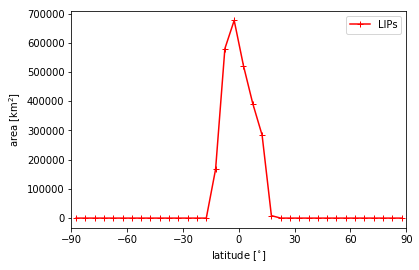

In [9]:
cols = ['area_km2','minimum_latitude','maximum_latitude']

df_LIPs = pd.DataFrame({'minimum_latitude':lat_mins, 'maximum_latitude':lat_maxs, 'area_km2':areas_LIPs})
df_LIPs = df_LIPs[cols]

fig, ax = plt.subplots()
ax.plot((df_LIPs['minimum_latitude']+(df_LIPs['maximum_latitude']-df_LIPs['minimum_latitude'])/2), \
        df_LIPs['area_km2'], 'r+-', label='LIPs')
ax.set_xlabel('latitude [$^{\circ}$]')
ax.set_ylabel('area [km$^{2}$]')
ax.set_xlim(-90,90)
ax.set_xticks([-90,-60,-30,0,30,60,90])
ax.legend()
plt.show(fig)

In [10]:
np.sum(df_LIPs[(df_LIPs['minimum_latitude']>=-15)&(df_LIPs['maximum_latitude']<=15)]['area_km2'])

2620997.0487505244

### Umkondo

In [11]:
# create the latitude bands
# band_width must be a factor of 90
band_width = 5
lat_mins = np.arange(-90           , 90           , band_width)
lat_maxs = np.arange(-90+band_width, 90+band_width, band_width)
lat_mids = lat_mins + (lat_maxs-lat_mins)/2

In [12]:
# input parameters
t = 1109     #reconstruction time
anchor = 1  #anchor plate ID

# carry out the reconstruction for the LIPs
reconstructed_LIPs = []
pygplates.reconstruct(Umkondo, model, reconstructed_LIPs, t, anchor)

In [13]:
# perform the calculations for LIPs
areas_LIPs, area_polygons_LIPs = get_areas_in_bands(reconstructed_LIPs, lat_mins, lat_maxs)

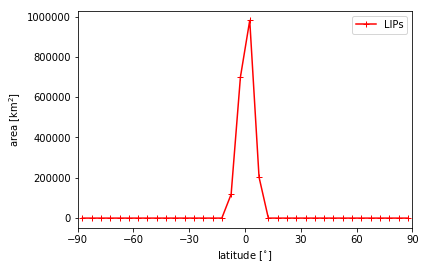

In [14]:
cols = ['area_km2','minimum_latitude','maximum_latitude']

df_LIPs = pd.DataFrame({'minimum_latitude':lat_mins, 'maximum_latitude':lat_maxs, 'area_km2':areas_LIPs})
df_LIPs = df_LIPs[cols]

fig, ax = plt.subplots()
ax.plot((df_LIPs['minimum_latitude']+(df_LIPs['maximum_latitude']-df_LIPs['minimum_latitude'])/2), \
        df_LIPs['area_km2'], 'r+-', label='LIPs')
ax.set_xlabel('latitude [$^{\circ}$]')
ax.set_ylabel('area [km$^{2}$]')
ax.set_xlim(-90,90)
ax.set_xticks([-90,-60,-30,0,30,60,90])
ax.legend()
plt.show(fig)

In [15]:
np.sum(df_LIPs[(df_LIPs['minimum_latitude']>=-15)&(df_LIPs['maximum_latitude']<=15)]['area_km2'])

2002627.6139613984